# Logistic Regression

## Environment setup

In [1]:
import platform

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

Python version: 3.7.5


In [2]:
# Setup plots
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()

In [3]:
import sklearn

print(f"scikit-learn version: {sklearn.__version__}")
assert sklearn.__version__ >= "0.20"

from sklearn.datasets import make_classification, make_blobs
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report

scikit-learn version: 0.22.1


In [4]:
def plot_data(x, y):
    """Plot some 2D data"""

    fig, ax = plt.subplots()
    scatter = ax.scatter(x[:, 0], x[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Classes")
    ax.add_artist(legend1)
    plt.xlim((min(x[:, 0]) - 0.1, max(x[:, 0]) + 0.1))
    plt.ylim((min(x[:, 1]) - 0.1, max(x[:, 1]) + 0.1))


def plot_decision_boundary(pred_func, x, y, figure=None):
    """Plot a decision boundary"""

    if figure is None:  # If no figure is given, create a new one
        plt.figure()
    # Set min and max values and give it some padding
    x_min, x_max = x[:, 0].min() - 0.5, x[:, 0].max() + 0.5
    y_min, y_max = x[:, 1].min() - 0.5, x[:, 1].max() + 0.5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    cm_bright = ListedColormap(["#FF0000", "#00FF00", "#0000FF"])
    plt.scatter(x[:, 0], x[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)

## Binary classification

### Problem formulation

Logistic regression is a classification algorithm used to estimate the probability that a data sample belongs to a particular class.

A logistic regression model computes a weighted sum of the input features (plus a bias term), then applies the [logistic function](activations:sigmoid) to this sum in order to output a probability.

$$y' = \mathcal{h}_\theta(\pmb{x}) = \sigma(\pmb{\theta}^T\pmb{x})$$

The function output is thresholded to form the model's prediction:

- $0$ if $y' \lt 0.5$
- $1$ if $y' \geqslant 0.5$

### Loss function: Binary Crossentropy (log loss)

See [loss definition](loss:bce) for details.

### Model training

- No analytical solution because of the non-linear $\sigma()$ function: gradient descent is the only option.
- Since the loss function is convex, GD (with the right hyperparameters) is guaranteed to find the global loss minimum.
- Different GD optimizers exist: *newton-cg*, *l-bfgs*, *sag*... *Stochastic gradient descent* is another possibility, efficient for large numbers of samples and features.

$$\nabla_{\theta}\mathcal{L}(\pmb{\theta}) = \begin{pmatrix}
       \ \frac{\partial}{\partial \theta_0} \mathcal{L}(\boldsymbol{\theta}) \\
       \ \frac{\partial}{\partial \theta_1} \mathcal{L}(\boldsymbol{\theta}) \\
       \ \vdots \\
       \ \frac{\partial}{\partial \theta_n} \mathcal{L}(\boldsymbol{\theta})
     \end{pmatrix} = \frac{2}{m}\pmb{X}^T\left(\sigma(\pmb{X}\pmb{\theta}) - \pmb{y}\right)$$

### Example: classify planar data

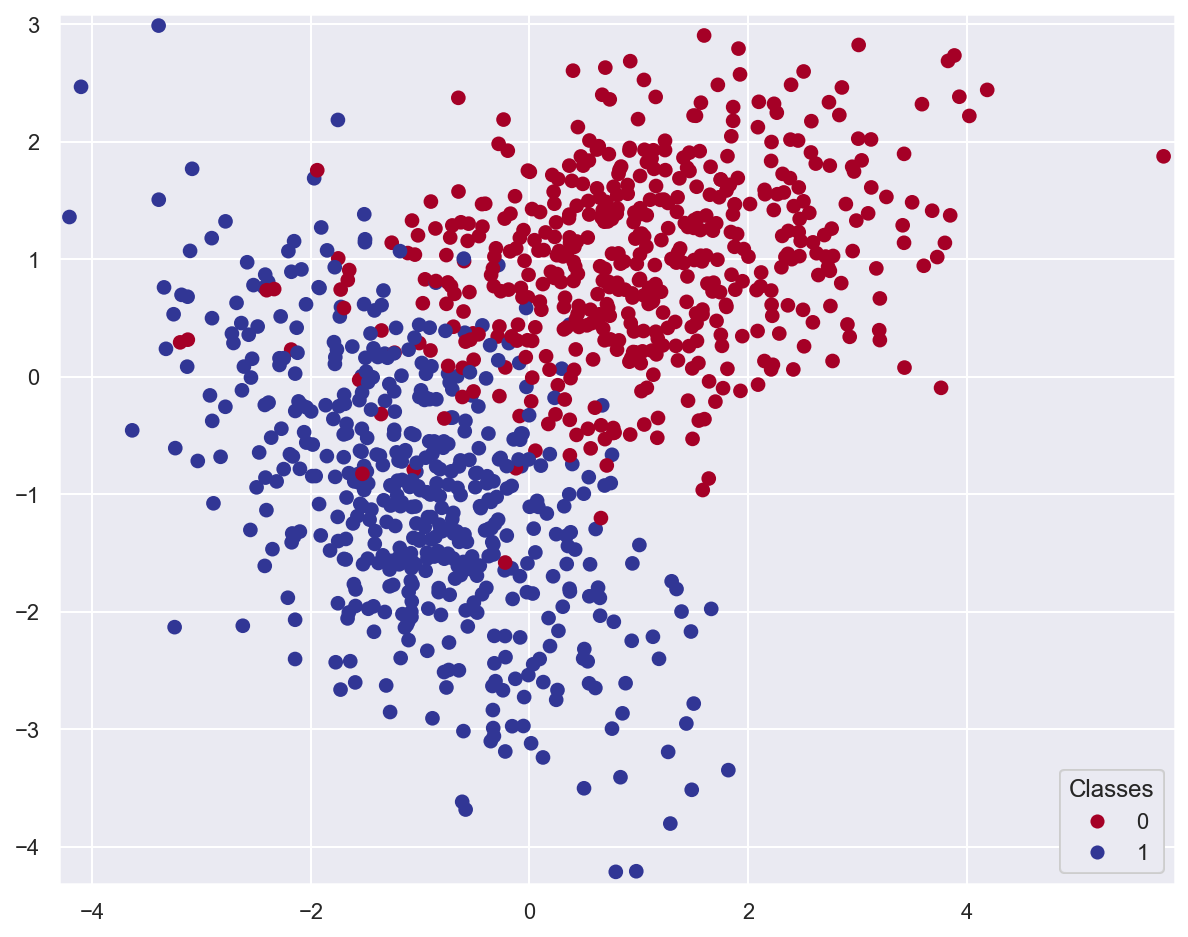

In [5]:
# Generate 2 classes of linearly separable data
x_train, y_train = make_classification(
    n_samples=1000,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=26,
    n_clusters_per_class=1,
)
plot_data(x_train, y_train)

In [6]:
# Create a Logistic Regression model based on stochastic gradient descent
# Alternative: using the LogisticRegression class which implements many GD optimizers
lr_model = SGDClassifier(loss="log")

# Train the model
lr_model.fit(x_train, y_train)

print(f"Model weights: {lr_model.coef_}, bias: {lr_model.intercept_}")

Model weights: [[-2.96719034 -2.55668143]], bias: [-0.57585284]


In [7]:
# Print report with classification metrics
print(classification_report(y_train, lr_model.predict(x_train)))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       502
           1       0.92      0.96      0.94       498

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



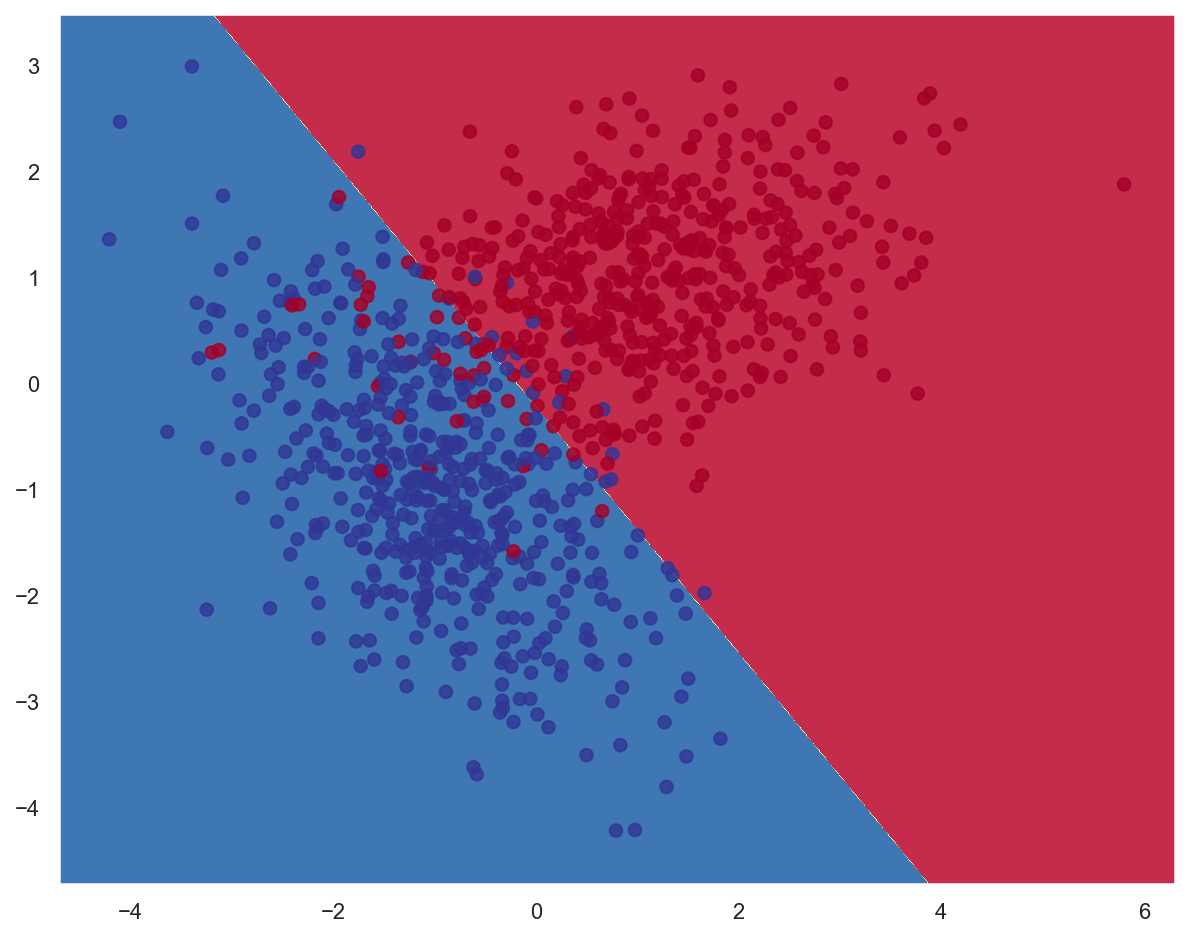

In [8]:
# Plot decision boundary
plot_decision_boundary(lambda x: lr_model.predict(x), x_train, y_train)

## Multivariate regression

### Problem formulation

**Multivariate regression**, also called *softmax regression*, is a generalization of logistic regression for multiclass classification.

A softmax regression model computes the scores $s_k(\pmb{x})$ for each class $k$, then estimates probabilities for each class by applying the [softmax](activations:softmax) function to compute a probability distribution.

For a sample $\pmb{x}^{(i)}$, the model predicts the class $k$ that has the highest probability.

$$s_k(\pmb{x}) = {\pmb{\theta}^{(k)}}^T\pmb{x}$$

$$\mathrm{prediction} = \underset{k}{\mathrm{argmax}}\;\sigma(s(\pmb{x}^{(i)}))_k$$

Each class $k$ has its own parameter vector $\pmb{\theta}^{(k)}$.

### Model output

- $\pmb{y}^{(i)}$ (*ground truth*): **binary vector** of $K$ values. $y^{(i)}_k$ is equal to 1 if the $i$th sample's class corresponds to $k$, 0 otherwise.
- $\pmb{y}'^{(i)}$: **probability vector** of $K$ values, computed by the model. $y'^{(i)}_k$ represents the probability that the $i$th sample belongs to class $k$.

$$\pmb{y}^{(i)} = \begin{pmatrix}
       \ y^{(i)}_1 \\
       \ y^{(i)}_2 \\
       \ \vdots \\
       \ y^{(i)}_K
     \end{pmatrix} \in \pmb{R}^K\;\;\;\;
\pmb{y}'^{(i)} = \begin{pmatrix}
       \ y'^{(i)}_1 \\
       \ y'^{(i)}_2 \\
       \ \vdots \\
       \ y'^{(i)}_K
     \end{pmatrix} = \begin{pmatrix}
       \ \sigma(s(\pmb{x}^{(i)}))_1 \\
       \ \sigma(s(\pmb{x}^{(i)}))_2 \\
       \ \vdots \\
       \ \sigma(s(\pmb{x}^{(i)}))_K
     \end{pmatrix} \in \pmb{R}^K$$

### Loss function: Categorical Crossentropy

See [loss definition](loss:cce) for details.

### Model training

Via gradient descent:

$$\nabla_{\theta^{(k)}}\mathcal{L}(\pmb{\theta}) = \frac{1}{m}\sum_{i=1}^m \left(y'^{(i)}_k - y^{(i)}_k \right)\pmb{x}^{(i)}$$

$$\pmb{\theta}^{(k)}_{next} = \pmb{\theta}^{(k)} - \eta\nabla_{\theta^{(k)}}\mathcal{L}(\pmb{\theta})$$

### Example: classify multiclass planar data

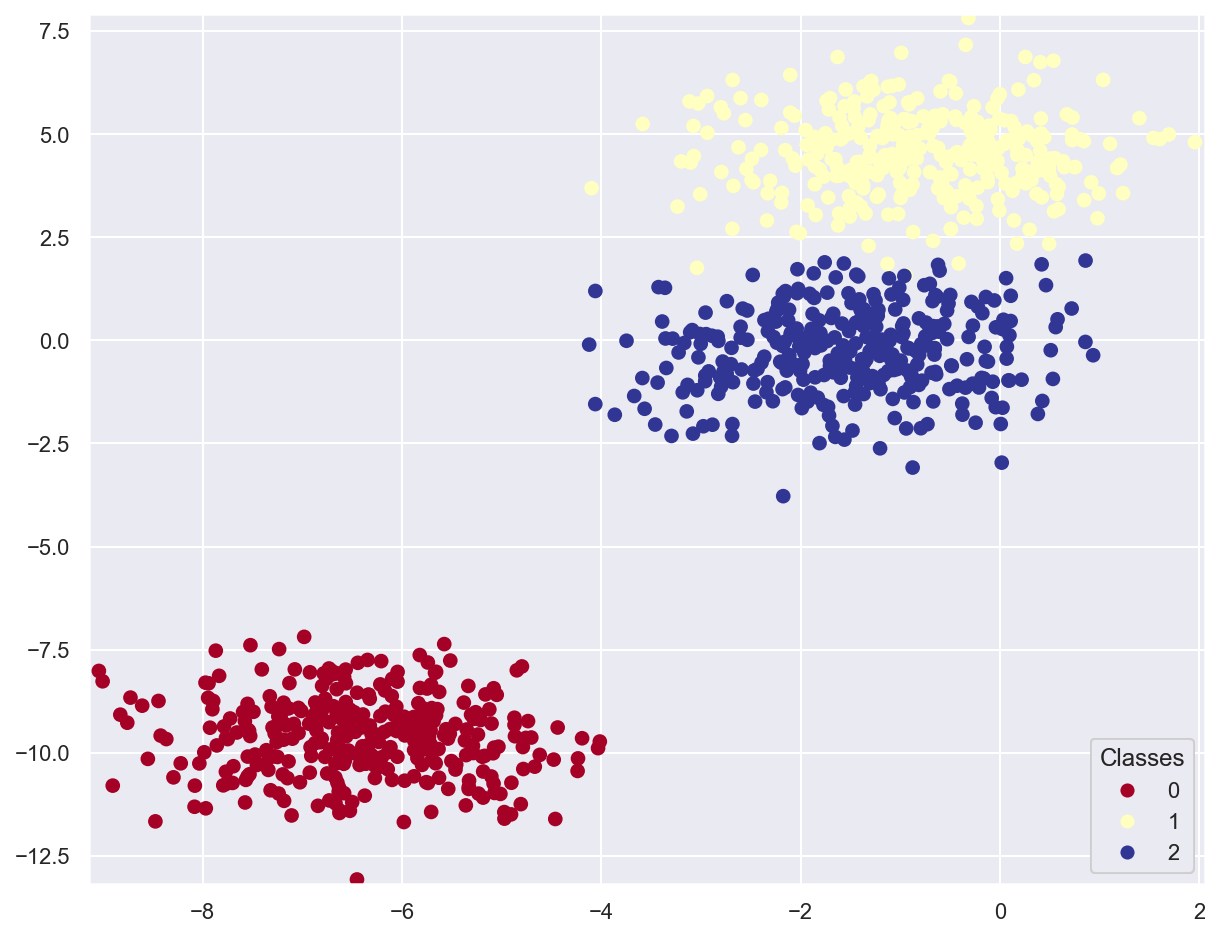

In [9]:
# Generate 3 classes of linearly separable data
x_train_multi, y_train_multi = make_blobs(n_samples=1000, n_features=2, centers=3, random_state=11)

plot_data(x_train_multi, y_train_multi)

In [10]:
# Create a Logistic Regression model based on stochastic gradient descent
# Alternative: using LogisticRegression(multi_class="multinomial") which implements SR
lr_model_multi = SGDClassifier(loss="log")

# Train the model
lr_model_multi.fit(x_train_multi, y_train_multi)

print(f"Model weights: {lr_model_multi.coef_}, bias: {lr_model_multi.intercept_}")

Model weights: [[ -5.76624648 -17.43149458]
 [ -1.27339599  19.17812979]
 [  1.5231193   -0.91647832]], bias: [-133.15588019  -38.36388245    2.53712564]


In [11]:
# Print report with classification metrics
print(classification_report(y_train_multi, lr_model_multi.predict(x_train_multi)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       334
           1       0.99      0.99      0.99       333
           2       0.99      0.99      0.99       333

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       1.00      0.99      0.99      1000



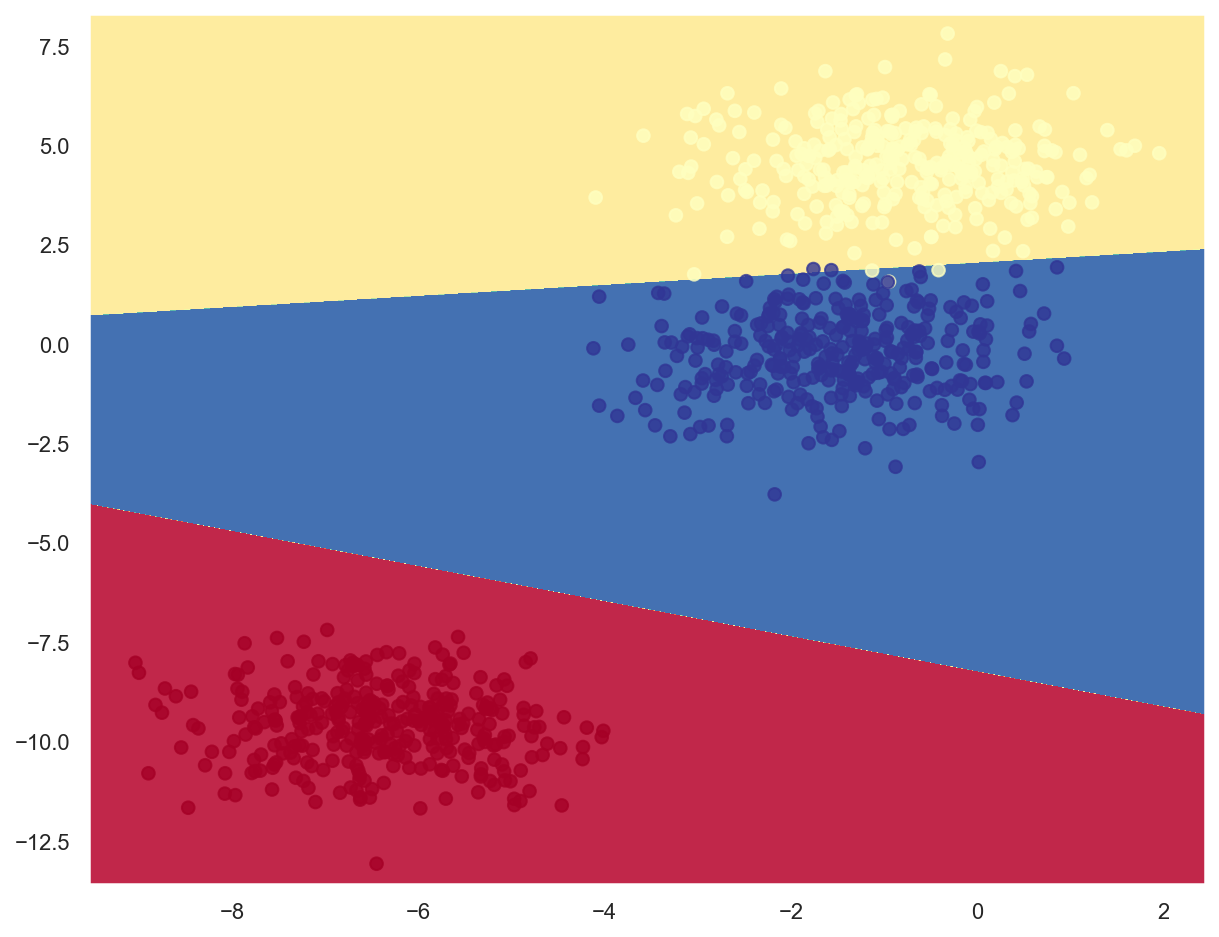

In [12]:
# Plot decision boundaries
plot_decision_boundary(lambda x: lr_model_multi.predict(x), x_train_multi, y_train_multi)